In [1]:
import yfinance as yf 
import pandas as pd  
import numpy as np 

import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD
# Set Random seed
import random
random.seed(42)

In [2]:
aapl= yf.Ticker("aapl")
aapl_historical = aapl.history(start="2016-12-01", interval="1d")

In [3]:
df = aapl_historical.drop(['Volume','Dividends','Stock Splits'],axis=1)  
df.head()

,Open,High,Low,Close
Date,,,,
2016-12-01 00:00:00-05:00,25.747475,25.880447,25.434875,25.542185
2016-12-02 00:00:00-05:00,25.467535,25.682155,25.392884,25.637833
2016-12-05 00:00:00-05:00,25.661151,25.668149,25.252906,25.453529
2016-12-06 00:00:00-05:00,25.544517,25.745141,25.472200,25.649494
2016-12-07 00:00:00-05:00,25.488527,25.938764,25.465199,25.901438


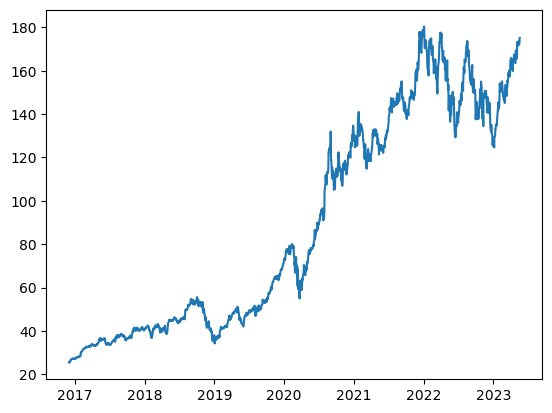

In [4]:
plt.plot(df['Close'])

In [5]:
column_names = df.columns
x = df.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled)
df2 = df2
df2.columns = column_names
df2

,Open,High,Low,Close
0,0.001799,0.001364,0.001195,0.000572
1,0.000000,0.000090,0.000919,0.001189
2,0.001244,0.000000,0.000000,0.000000
3,0.000495,0.000495,0.001440,0.001264
4,0.000135,0.001738,0.001394,0.002890
...,...,...,...,...
1622,0.949294,0.947676,0.959956,0.946030
1623,0.941774,0.947226,0.962123,0.946030
1624,0.939974,0.945877,0.953063,0.950031
1625,0.948265,0.960715,0.967244,0.965258


In [6]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 30 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(df2.shape[0] - samples):
    X.append(df2.iloc[i:i+samples, 0:3].values) # Independent Samples
    Y.append(df2.iloc[i+samples, 3:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  30 :  [array([[1.79931640e-03, 1.36360556e-03, 1.19467799e-03],
       [0.00000000e+00, 8.99605355e-05, 9.19000209e-04],
       [1.24446868e-03, 0.00000000e+00, 0.00000000e+00],
       [4.94804290e-04, 4.94525212e-04, 1.43972993e-03],
       [1.34927071e-04, 1.73818325e-03, 1.39376685e-03],
       [2.53398930e-03, 3.59617568e-03, 3.59919768e-03],
       [4.70819027e-03, 6.99757562e-03, 6.21821534e-03],
       [6.17761354e-03, 7.44707820e-03, 6.49387605e-03],
       [7.00226480e-03, 8.82557629e-03, 8.42362908e-03],
       [8.80158578e-03, 9.24512668e-03, 1.03074648e-02],
       [9.31141725e-03, 1.00393204e-02, 1.06903891e-02],
       [1.09457841e-02, 9.69466676e-03, 1.13336291e-02],
       [9.94119582e-03, 1.10132819e-02, 1.14868103e-02],
       [1.13506259e-02, 1.11930688e-02, 1.29111451e-02],
       [1.14406005e-02, 1.10432321e-02, 1.30643009e-02],
       [1.07658438e-02, 9.70964918e-03, 1.13183053e-02],
       [9.62632089e-03, 9.72467124e-03, 1.12417690e-02]

In [7]:
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1597, 30, 3) Dimensions of Y (1597, 1)


In [8]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1437, 30, 3) (1437, 1) Testing Length: (160, 30, 3) (160, 1)


In [9]:
regressor = Sequential()

# add first layer with dropout

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
regressor.add(Dropout(0.2))

# add second layer

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add third layer

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add fourth layer

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# the output layer

regressor.add(Dense(units=1))    


regressor.compile(optimizer='adam', loss='mean_squared_error')

2023-05-19 15:12:27.915736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
lstm_trained = regressor.fit(trainX,
                              trainY,
                              shuffle = False, # Since this is time series data
                              epochs=50,
                              batch_size=120,
                              validation_split=0.2,
                              verbose=0) # Verbose outputs data

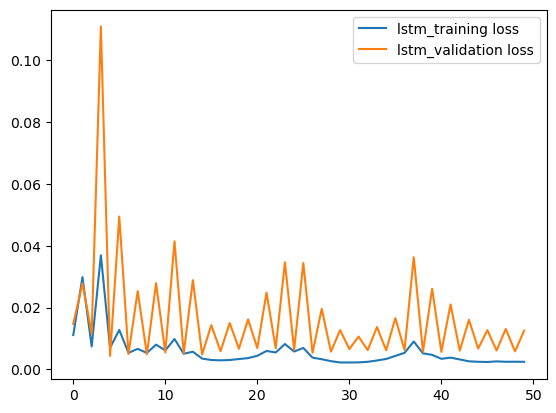

In [11]:
plt.plot(lstm_trained.history['loss'], label = 'lstm_training loss')
plt.plot(lstm_trained.history['val_loss'], label ='lstm_validation loss')
plt.legend()

5/5 [==============================] - 1s 10ms/step


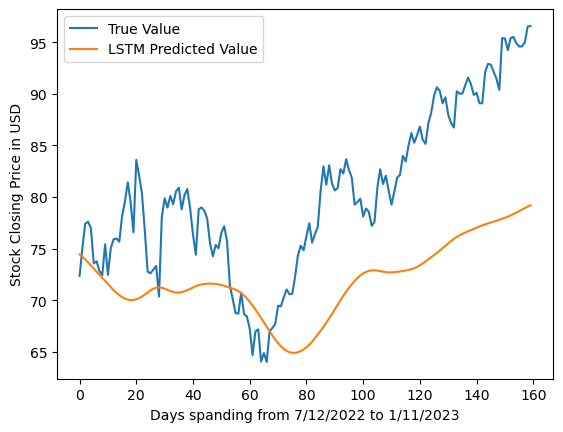

In [12]:
y_pred = regressor.predict(testX)       
testY = testY*100   
y_pred = y_pred*100
plt.plot(testY, label = 'True Value')   
plt.plot(y_pred[:,0],label='LSTM Predicted Value')  
plt.xlabel("Days spanding from 7/12/2022 to 1/11/2023") 
plt.ylabel("Stock Closing Price in USD")
plt.legend()

In [13]:
print(y_pred.shape)

(160, 1)


In [14]:
print(testY.shape)

(160, 1)


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
output_index = 0  # Index of the output column to evaluate
mse = mean_squared_error(testY, y_pred)
mae = mean_absolute_error(testY, y_pred)
r2 = r2_score(testY, y_pred) 


print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 98.36433821595874
Mean Absolute Error (MAE): 8.611502349675026
R-squared Score (R2): -0.5557732262696411
